# Assignment 7
## Gal Dali

### Question 1

#### The Shooting method

$$\begin{cases}
\ddot{y}_1+\frac{1}{t} \dot y_{1} - y_2^{3}(y_1^{2}+1)=0\\
\ddot{y}_2+\frac{3}{t} \dot y_{2} + y_2^{5}(y_1^{2}+3)=0
\end{cases}$$

$$\begin{cases}
y_1(1)=1 & y_1(2)=\sqrt{5}\\
y_2(1)=1 & y_2(2)=\frac{1}{\sqrt{5}}
\end{cases}$$
$ t = 1 ... 2 $

$ \text{Similar to what we saw in recitation, I will write the following equivalent system of first order ODEs: }$

$$\begin{cases}
\dot y_1 = y_3 & y_1(1) = 1\\
\dot y_2 = y_4 & y_2(1) = 1\\
\dot y_3 = -\frac {1}{t} y_3 + y_2^3 (y_1^2 +1) & y_3(1) = ?\\
\dot y_4 = -\frac {3}{t} y_4 - y_2^5 (y_1^2 + 3) & y_4(1) = ?\\
\end{cases}$$


In [124]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [125]:
# Define the system of ODEs I wrote above
def f(t, y):
    y1, y2, y3, y4 = y
    return np.array([y3, y4, -(1 / t) * y3 + (y2 ** 3) * (y1 ** 2 + 1), -(3 / t) * y4 - (y2 ** 5) * (y1 ** 2 + 3)])

In [126]:
# initial conditions
y1_y2_at_1 = np.array([1, 1])
y1_y2_at_2 = np.array([np.sqrt(5), 1 / np.sqrt(5)])

# guess for y3 and y4 (I only need to use the initial conditions for time t = 1, but if I want to shoot from the other side, I can too)
guess_y3_y4_at_1 = np.array([1.2, -0.6])  # initial guess for y3 and y4
# guess_y3_y4_at_2 = np.array([2.5, 0.5])  # initial guess for y3 and y4 (the other boundary)

# time span
t_span = (1, 2)
t_eval = np.linspace(*t_span, 100)

$$\begin{cases}
y_1(2)=\sqrt{5}\\
y_2(2)=\frac{1}{\sqrt{5}}
\end{cases}$$

$\text{The "Fisfus" function (the best name ever)}$
$$\begin{cases}
F_1 = y_1(t_2 | y_3(1), y_4(1)) - \sqrt{5}\\
F_2 = y_2(t_2 | y_3(1), y_4(1)) - \frac{1}{\sqrt{5}}
\end{cases}$$

In [127]:
# The "Fisfus" function (lol)
# The only "true" argument for F is our guess.
# The rest are more like parameters and are defined outside the function.
def F(guess_y_at_1_F: np.array) -> np.ndarray:
    y_at_1_F = np.hstack((y1_y2_at_1, guess_y_at_1_F))
    sol_F = solve_ivp(f, t_span, y_at_1_F, t_eval=t_eval)
    return sol_F.y[:2, -1] - y1_y2_at_2

$\text{The Jacobian of the "Fisfus" function (I love saying that)}$
$$
J = \begin{pmatrix}
\frac{\partial F_1}{\partial{y_3(1)}} & \frac{\partial F_1}{\partial{y_4(1)}} \\
\frac{\partial F_2}{\partial{y_3(1)}} & \frac{\partial F_2}{\partial{y_4(1)}}
\end{pmatrix}
$$

$ \text{Since the F function (functor) is dependent on a numerical calculation, we simply can't solve for J analytically. } $
$ \text{Unfortunately, we must turn to less accurate numerical methods.}$

$$
\begin{align*}
\frac{\partial F_1}{\partial y_3(1)} &= \frac{F_1(y_3(1) + h, y_4(1)) - F_1(y_3(1), y_4(1))}{h} \\
\frac{\partial F_1}{\partial y_4(1)} &= \frac{F_1(y_3(1), y_4(1) + h) - F_1(y_3(1), y_4(1))}{h} \\
\frac{\partial F_2}{\partial y_3(1)} &= \frac{F_1(y_3(1) + h, y_4(1)) - F_1(y_3(1), y_4(1))}{h} \\
\frac{\partial F_2}{\partial y_4(1)} &= \frac{F_1(y_3(1), y_4(1) + h) - F_1(y_3(1), y_4(1))}{h}
\end{align*}
$$

In [128]:
# Find the Jacobian matrix numerically (The worst part of this method, also I had a bug here where I accidentally divided by h twice, classic bug)
def J(guess_y_at_1_F: np.array, h: float = 1e-5) -> np.ndarray:
    F_at_guess = F(guess_y_at_1_F)  # F(y_3(1), y_4(1))
    F_at_guess_plus_h_1 = F(guess_y_at_1_F + np.array([h, 0]))  # F(y_3(1) + h, y_4(1))
    F_at_guess_plus_h_2 = F(guess_y_at_1_F + np.array([0, h]))  # F(y_3(1), y_4(1) + h)
    return (1 / h) * np.array([
        [(F_at_guess_plus_h_1[0] - F_at_guess[0]), (F_at_guess_plus_h_2[0] - F_at_guess[0])],
        [(F_at_guess_plus_h_1[1] - F_at_guess[1]), (F_at_guess_plus_h_2[1] - F_at_guess[1])]
    ])

$$J \cdot \begin{pmatrix}
\Delta s_3 \\
\Delta s_4
\end{pmatrix} = -F$$

$ \text{We now wish to solve for the vector } \vec \Delta s = \begin{pmatrix} \Delta s_3 \\ \Delta s_4 \end{pmatrix} \text{ using Newton-Raphson method.} $

In [129]:
# Newton-Raphson method
def NR_shooting(guess_y_at_1_NR: np.array, tol: float = 1e-5) -> np.array:
    delta_s_NR = np.inf
    corrected_guess_NR = guess_y_at_1_NR
    # shoot and correct your aim until you hit
    while np.linalg.norm(delta_s_NR) > tol:
        delta_s_NR = -1 * np.linalg.solve(J(corrected_guess_NR), F(corrected_guess_NR))
        corrected_guess_NR = corrected_guess_NR + delta_s_NR  # correct the guess
    return corrected_guess_NR

For some reason, I can't get the right solution :( I really try to understand why, but for some reason my code just doesn't work :(((((

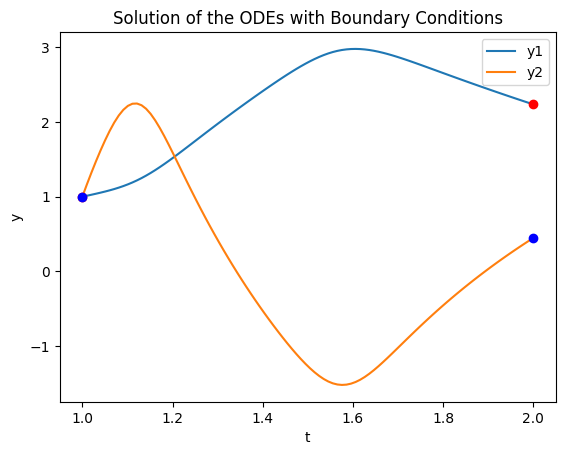

This solution is wrong, and I have no clue what so ever why I failed to solve it :((((((((((((((((((((((((((. also, slightly modifying the guess really affects the results


In [130]:
# Solve the problem. NOTE: if this runs for too long, that means your guess is bad! It also seems like the tolerance can heavily affect the calculation time. This method seems pretty hard to use since you really have to be smart when guessing and know how to pick a good tolerance

# Find the corrected initial conditions
better_guess = NR_shooting(guess_y3_y4_at_1)
y_at_1 = np.hstack((y1_y2_at_1, better_guess))

# Solve the ODEs
ode_solution = solve_ivp(f, t_span, y_at_1, t_eval=t_eval)

# Plot the solution and the boundary conditions: y1(1) = 1, y_1(2) = sqrt(5), y_2(1) = 1, y_2(2) = 1/sqrt(5)
plt.plot(ode_solution.t, ode_solution.y[0], label='y1')
plt.plot(ode_solution.t, ode_solution.y[1], label='y2')

# Add the boundary condition points
plt.scatter([1, 2], [1, np.sqrt(5)], color='red', zorder=5)  # y1 boundary conditions
plt.scatter([1, 2], [1, 1 / np.sqrt(5)], color='blue', zorder=5)  # y2 boundary conditions

plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.title('Solution of the ODEs with Boundary Conditions')
plt.show()
print("This solution is wrong, and I have no clue what so ever why I failed to solve it :((((((((((((((((((((((((((. also, slightly modifying the guess really affects the results")

Note: I implemented the methods in python in an ad-hoc manner for the specific problem I was facing because it was easier to implement. Using this codebase is not meant for general purpose problems, but the logic can still be gleaned from it for more general use cases. But my solution is wrong so never mind :(

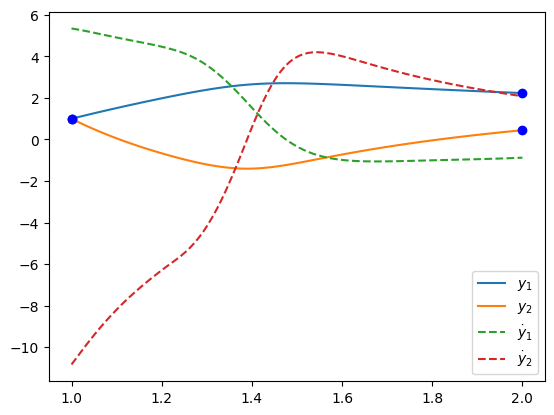

In [131]:
# Solution using the code I was given
def f(t, y):
    y1, y2, y3, y4 = y
    return np.array([y3, y4, -(1 / t) * y3 + (y2 ** 3) * (y1 ** 2 + 1), -(3 / t) * y4 - (y2 ** 5) * (y1 ** 2 + 3)])

y0s = np.array([1,1]) # known initial values
yfs = np.array([np.sqrt(5), 1 / np.sqrt(5)]) # known final values
tspan = (1,2)

y2_guess = 1.2
y3_guess = -0.6
y0g = np.array([y2_guess, y3_guess]) # guessed initial values

def F(y0g):
  y0 = np.hstack((y0s,y0g)) # all initial values
  sol = solve_ivp(f,tspan,y0)
  return sol.y[:2,-1] - yfs   # dist from known final values

def J(y0g):
  h = 0.001
  F_vv = F(y0g) # F(y03, y04)
  F_vhv = F(y0g+h*np.array([1,0])) # F(y03+h, y04)
  F_vvh = F(y0g+h*np.array([0,1])) # F(y03, y04+h)
  return (1/h) * np.array([
      [F_vhv[0] - F_vv[0] , F_vvh[0] - F_vv[0]],
      [F_vhv[1] - F_vv[1] , F_vvh[1] - F_vv[1]]
  ])

def NR_shooting(y0g):
  tol = 1e-5
  delta_s = np.inf
  while np.linalg.norm(delta_s) > tol:
    delta_s = -1 * np.linalg.solve(J(y0g),F(y0g))
    y0g = y0g + delta_s   # update initial guess
  return y0g

y0g = NR_shooting(y0g)
y0 = np.hstack((y0s,y0g)) # initial values with the updated guess
t_eval = np.linspace(tspan[0],tspan[1],100)
sol = solve_ivp(f,tspan,y0,t_eval=t_eval)

# This also yields a wrong solution. IDK why :(
plt.plot(sol.t, sol.y[0], label=r'$y_1$')
plt.plot(sol.t, sol.y[1], label=r'$y_2$')
plt.plot(sol.t, sol.y[2], '--', label=r'$\dot{y}_1$')
plt.plot(sol.t, sol.y[3], '--', label=r'$\dot{y}_2$')
plt.plot(tspan, [y0s[0],yfs[0]], 'bo')
plt.plot(tspan, [y0s[1],yfs[1]], 'bo')
plt.legend()
plt.show()

### Question 2

#### The Relaxation method

$$\ddot{\theta} = -\omega^2 \sin(\theta) - \gamma \dot{\theta}$$

$$\theta(0) = \theta_0, \quad \theta(t_f) = 0$$

$$\dot \theta = s$$

$$\dot s = -\omega^2 \sin(\theta) - \gamma s$$

$ \frac{\theta_{i+1} - \theta_i}{h} = \frac{s_i + s_{i+1}}{2} $
$ \frac{s_{i+1} - s_i}{h} = \omega^2 \sin(\frac{\theta_i + \theta_{i+1}}{2}) - \gamma \frac{s_i + s_{i+1}}{2} $

In [132]:
y0 = np.pi/4
yf = 0
w = 1

N = 1000  # number of segments
N_eq = 2*N  # number of equations

tspan = (0,10)
t_val = np.linspace(tspan[0],tspan[1],N+1) # edges of N segments
h = (tspan[1] - tspan[0]) / N

def F(y,s):
  f = np.zeros(N_eq)
  for i in range(N):
    f[2*i] = y[i+1] - y[i] - 0.5*h*(s[i]+s[i+1])
    f[2*i+1] = s[i+1] - s[i] + h*(w**2)*np.sin(0.5*(y[i]+y[i+1]))
  return f

def J(y,s):
  M = np.zeros((N_eq,N_eq))
  M[0,0:3] = np.array([-0.5*h, 1, -0.5*h])
  M[1,0:3] = np.array([-1, 0.5*h*(w**2)*np.cos(0.5*(y[0]+y[1])), 1])
  for i in range(1,N-1):
    j = 2*i
    c = 0.5*h*(w**2)*np.cos(0.5*(y[i]+y[i+1]))  # c_i,j
    M[j,j-1:j+3] = np.array([-1, -0.5*h, 1, -0.5*h])
    M[j+1,j-1:j+3] = np.array([c, -1, c, 1])
  M[-2,-3:] = np.array([-1, -0.5*h, -0.5*h])
  M[-1,-3:] = np.array([0.5*h*(w**2)*np.cos(0.5*(y[-2]+y[-1])), -1, 1])
  return csr_matrix(M)

def NR_relax(y,s):
  tol = 1e-5
  delta_x = np.inf
  # convert from y,s to x:
  x = np.zeros(N_eq)
  x[0::2] = s[:-1]
  x[-1] = s[-1]
  x[1:-1:2] = y[1:-1]
  while np.linalg.norm(delta_x) > tol:
    delta_x = -1 * spsolve(J(y,s),F(y,s))
    x = x + delta_x
    # update y,s according to x:
    y = np.hstack(([y0],x[1:N_eq-1:2],[yf]))
    s = np.hstack((x[0::2], x[-1]))
  return y,s

# initial guesses for all variables:
s = ((yf-y0)/(tspan[1]-tspan[0])) * np.ones(N+1)
y = y0 + s[0]*t_val
# make sure known values are correct:
y[0] = y0
y[-1] = yf

y,s = NR_relax(y,s) # find the correct variables

NameError: name 'spsolve' is not defined